In [1]:
from actor_critic_agent import ActorCriticAgent
from env_wrapper import EnvironmentWrapper
import gymnasium as gym
import numpy as np

In [2]:
# Configurable hyperparameters
config = {
    'experiment': 'Acrobot',
    'device': 'cuda',
    'state_size': 6, 
    'action_size': 3, 
    'hidden_sizes': [64, 64], 
    'lr_actor': 0.001,
    'lr_critic': 0.005,
    'verbosity': 10,
    'env_name': 'Acrobot-v1',
    'gamma': 0.99, # Discount factor
    'reward_threshold': -85.0,
    'max_episodes': 2000,
    'max_steps': 200,
    'update_frequency': 200

}

In [3]:
# create a child class for acrobot with a updates reward
class AcrobotWrapper(EnvironmentWrapper):
    def __init__(self, env):
        super().__init__(env)
        
        self.ticker = 0


    def step(self, action):

        action = min(self.action_space-1, max(0, action))

        state, reward, done, _, info = self.env.step(action)

        if self.ticker < 250: # positive feedback handicap
            # Extract the two angles from the state
            cos_theta1, sin_theta1, cos_theta2, sin_theta2, _, _ = state
            # Convert cos and sin of theta1 and theta2 into their angles
            theta1 = np.arctan2(sin_theta1, cos_theta1)
            theta2 = np.arctan2(sin_theta2, cos_theta2)
            # Calculate the vertical position of the free end
            vertical_position = -np.cos(theta1) - np.cos(theta2 + theta1)
            # Define a custom reward based on the vertical position
            reward += vertical_position  # Reward based on vertical position and step
            # Pad state to match target_state_size

        padded_state = np.append(state, np.zeros(self.target_state_size - len(state)))

        self.ticker += 1
        
        return padded_state, reward, done, info

In [4]:
# Initialize the environment
env = gym.make(config['env_name'])
env_wrapper = AcrobotWrapper(env)
# env_wrapper = AcrobotWrapper(env)

# Initialize the ActorCriticAgent
agent = ActorCriticAgent(config)

2024-03-12 12:19:22.164790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 12:19:22.268007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 12:19:22.268064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 12:19:22.269918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 12:19:22.284181: I tensorflow/core/platform/cpu_feature_guar

In [5]:
results = agent.train(env_wrapper, max_episodes=config['max_episodes'], max_steps=config['max_steps'], reward_threshold=config['reward_threshold'], update_frequency=config['update_frequency'])

Episode 0, Avg Reward: -590.3041340112686, PLoss: -647.6431274414062, VLoss: 1743.4964599609375
Episode 10, Avg Reward: -287.87069367278707, PLoss: -208.93084716796875, VLoss: 217.64569091796875
Episode 20, Avg Reward: -246.02750620955513, PLoss: -191.5892791748047, VLoss: 366.8619689941406
Episode 30, Avg Reward: -231.17992356131154, PLoss: -174.46864318847656, VLoss: 1550.470947265625
Episode 40, Avg Reward: -223.5750641561136, PLoss: -69.3387451171875, VLoss: 642.2560424804688
Episode 50, Avg Reward: -218.95250255687563, PLoss: 182.9801483154297, VLoss: 2145.47119140625
Episode 60, Avg Reward: -215.84553492460094, PLoss: -21.236705780029297, VLoss: 568.8441162109375
Episode 70, Avg Reward: -213.6137694422628, PLoss: -72.8028564453125, VLoss: 4894.41845703125
Episode 80, Avg Reward: -211.93305716544023, PLoss: -51.482421875, VLoss: 359.3775939941406
Episode 90, Avg Reward: -210.62173220220504, PLoss: 168.16600036621094, VLoss: 4341.52783203125
Episode 100, Avg Reward: -205.7627349638

In [6]:
# save models
agent.save_models()

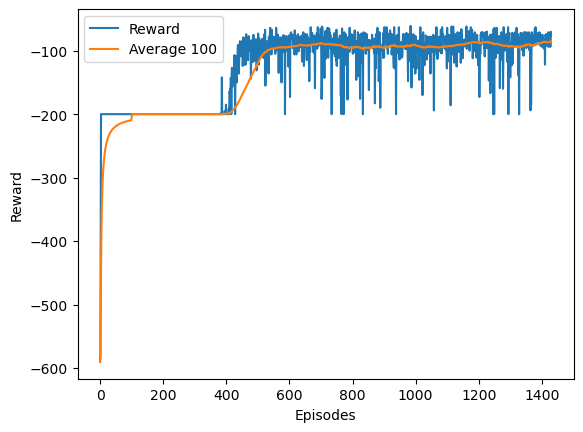

In [7]:
# plot results
import matplotlib.pyplot as plt

plt.plot(results['Episode'], results['Reward'], label='Reward')
plt.plot(results['Episode'], results['Average_100'], label='Average 100')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()


In [8]:
np.save(f'results/{config["experiment"]}', results)